In [90]:
import yfinance as yf
import pandas as pd

from pypfopt.efficient_frontier import EfficientFrontier 
from pypfopt import risk_models 
from pypfopt import expected_returns, get_latest_prices, DiscreteAllocation
from pypfopt.cla import CLA
import pypfopt.plotting as pplt

from collections import OrderedDict
from matplotlib.ticker import FuncFormatter

In [65]:
tickers = ['LKOH.ME','GMKN.ME', 'DSKY.ME', 'NKNC.ME', 'MTSS.ME', 'IRAO.ME', 'SBER.ME', 'AFLT.ME']
df_stocks= yf.download(tickers, start='2019-01-01', end='2021-12-01')['Adj Close']

df_stocks.tail()

[*********************100%***********************]  8 of 8 completed


Ticker,AFLT.ME,DSKY.ME,GMKN.ME,IRAO.ME,LKOH.ME,MTSS.ME,NKNC.ME,SBER.ME
Date,,,,,,,,
2021-11-24 00:00:00+00:00,64.279999,129.817535,22153.853516,4.4465,6474.578613,305.049988,121.599998,320.220001
2021-11-25 00:00:00+00:00,64.519997,130.662003,22127.871094,4.5445,6333.208008,305.799988,122.949997,317.880005
2021-11-26 00:00:00+00:00,61.080002,126.977066,21620.195312,4.3295,6060.429199,299.649994,119.000000,305.200012
2021-11-29 00:00:00+00:00,61.119999,131.679199,21572.224609,4.3325,6321.348145,295.799988,112.400002,316.640015
2021-11-30 00:00:00+00:00,60.320000,132.063049,21540.246094,4.2780,6212.236328,292.250000,116.550003,315.660004


In [67]:
nullin_df = pd.DataFrame(df_stocks,columns=tickers)
print(nullin_df.isnull().sum())

LKOH.ME    0
GMKN.ME    0
DSKY.ME    0
NKNC.ME    0
MTSS.ME    0
IRAO.ME    0
SBER.ME    0
AFLT.ME    0
dtype: int64


In [69]:
#Годовая доходность
mu = expected_returns.mean_historical_return(df_stocks) 
#Дисперсия портфеля
Sigma = risk_models.sample_cov(df_stocks)
#Максимальный коэффициент Шарпа

#Необходимо обратить внимание, что если изменить weight_bounds=(0,1) на weight_bounds=(-1,1), 
#то в портфеле будут учитываться и короткие позиции по акциям.
ef = EfficientFrontier(mu, Sigma, weight_bounds=(0,1)) #weight bounds in negative allows shorting of stocks
sharpe_pfolio=ef.max_sharpe() #May use add objective to ensure minimum zero weighting to individual stocks
sharpe_pwt=ef.clean_weights()
print(sharpe_pwt)

OrderedDict([('AFLT.ME', 0.0), ('DSKY.ME', 0.22606), ('GMKN.ME', 0.48796), ('IRAO.ME', 0.0), ('LKOH.ME', 0.0), ('MTSS.ME', 0.02953), ('NKNC.ME', 0.25645), ('SBER.ME', 0.0)])

OrderedDict({'AFLT.ME': 0.0, 'DSKY.ME': 0.16908, 'GMKN.ME': 0.03481, 'IRAO.ME': 0.0, 'LKOH.ME': 0.0, 'MTSS.ME': 0.43835, 'NKNC.ME': 0.21535, 'SBER.ME': 0.14242})


OrderedDict([('AFLT.ME', 0.0),
             ('DSKY.ME', 0.22606),
             ('GMKN.ME', 0.48796),
             ('IRAO.ME', 0.0),
             ('LKOH.ME', 0.0),
             ('MTSS.ME', 0.02953),
             ('NKNC.ME', 0.25645),
             ('SBER.ME', 0.0)])

In [94]:
ef1 = EfficientFrontier(mu, Sigma, weight_bounds=(0,1)) 
minvol=ef1.min_volatility()
minvol_pwt = ef1.clean_weights()
print(minvol_pwt)

OrderedDict([('AFLT.ME', 0.02876), ('DSKY.ME', 0.24503), ('GMKN.ME', 0.10403), ('IRAO.ME', 0.0938), ('LKOH.ME', 0.01168), ('MTSS.ME', 0.41967), ('NKNC.ME', 0.09704), ('SBER.ME', 0.0)])

ef1.portfolio_performance(verbose=True, risk_free_rate = 0.27)


OrderedDict({'AFLT.ME': 0.04229, 'DSKY.ME': 0.15553, 'GMKN.ME': 0.08715, 'IRAO.ME': 0.04963, 'LKOH.ME': 0.0, 'MTSS.ME': 0.59558, 'NKNC.ME': 0.06982, 'SBER.ME': 0.0})
Expected annual return: 20.6%
Annual volatility: 15.3%
Sharpe Ratio: -0.42


(0.2057470398569583, 0.15296701843947796, -0.4200445350803753)

In [71]:
ef.portfolio_performance(verbose=True)

Expected annual return: 26.9%
Annual volatility: 16.8%
Sharpe Ratio: 1.48


(0.2686864605900183, 0.16780794899126927, 1.4819706818713156)

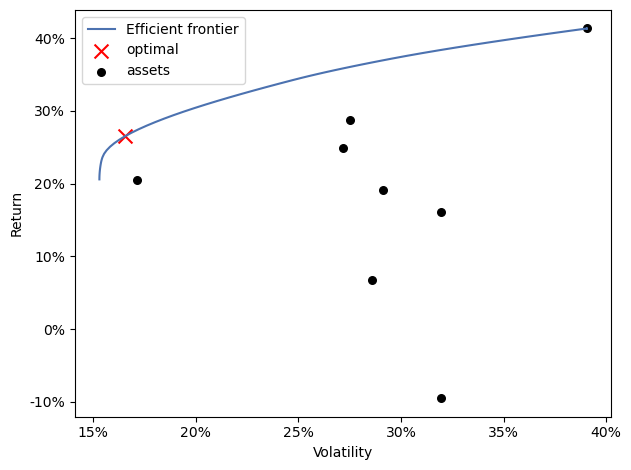

In [74]:
cl_obj = CLA(mu, Sigma)
ax = pplt.plot_efficient_frontier(cl_obj, showfig = False)
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

In [106]:
latest_prices = get_latest_prices(df_stocks)
allocation_minv, rem_minv = DiscreteAllocation(minvol_pwt, latest_prices, total_portfolio_value=1_000_000).lp_portfolio() 
print(allocation_minv)
print("Осталось денежных средств после построения портфеля с минимальной волатильностью - {:.2f} рублей".format(rem_minv))
print()

{'AFLT.ME': 702, 'DSKY.ME': 1179, 'GMKN.ME': 4, 'IRAO.ME': 11638, 'MTSS.ME': 2038, 'NKNC.ME': 600}
Осталось денежных средств после построения портфеля с минимальной волатильностью - 469.18 рублей



/opt/anaconda3/lib/python3.12/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [110]:
latest_prices1 = get_latest_prices(df_stocks)
allocation_shp, rem_shp = DiscreteAllocation(sharpe_pwt, latest_prices1, total_portfolio_value=1_000_000).lp_portfolio() 
print(allocation_shp)
print("Осталось денежных средств после построения портфеля с максимальным коэффициентом Шарпа {:.2f} рублей".format(rem_shp))

{'DSKY.ME': 1265, 'GMKN.ME': 2, 'MTSS.ME': 1492, 'NKNC.ME': 1830, 'SBER.ME': 445}
Осталось денежных средств после построения портфеля с максимальным коэффициентом Шарпа 67.54 рублей


# Кластеризация данных

In [173]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans 
from sklearn.preprocessing import MinMaxScaler

In [117]:
#function for Stock Returns computing 
def StockReturnsComputing(StockPrice, Rows, Columns):
    
    import numpy as np
    
    StockReturn = np.zeros([Rows-1, Columns])
    for j in range(Columns):  # j: Assets
        for i in range(Rows-1):     #i: Daily Prices
            StockReturn[i,j]=((StockPrice[i+1, j]-StockPrice[i,j])/StockPrice[i,j])

    return StockReturn

In [225]:
clusters = 3
scaler = MinMaxScaler()
df_cluster = scaler.fit_transform(df_stocks)


assetsCluster= KMeans(algorithm='auto',  max_iter=800, n_clusters=clusters)
print('Clustering of assets completed!') 
assetsCluster.fit(df_cluster[-180:].T)
centroids = assetsCluster.cluster_centers_
labels = assetsCluster.labels_

# print('Centroids:\n', centroids)
print('Labels:\n', labels)

Clustering of assets completed!
Labels:
 [1 2 2 1 0 2 0 0]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1420: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


In [231]:
df_cluster = pd.DataFrame(df_cluster, columns = df_stocks.columns)

In [227]:
#fixing asset labels to cluster points
print('Stocks in each of the clusters:\n',)
assets = np.array(df_stocks.columns)
for i in range(clusters):
    print('Cluster', i+1)
    clt  = np.where(labels == i)
    assetsCluster = assets[clt]
    print(assetsCluster)

Stocks in each of the clusters:

Cluster 1
['LKOH.ME' 'NKNC.ME' 'SBER.ME']
Cluster 2
['AFLT.ME' 'IRAO.ME']
Cluster 3
['DSKY.ME' 'GMKN.ME' 'MTSS.ME']


<Axes: >

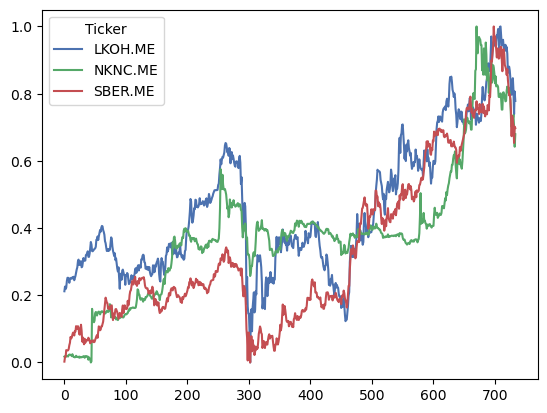

In [233]:
df_cluster.plot(y=['LKOH.ME', 'NKNC.ME', 'SBER.ME'])

<Axes: >

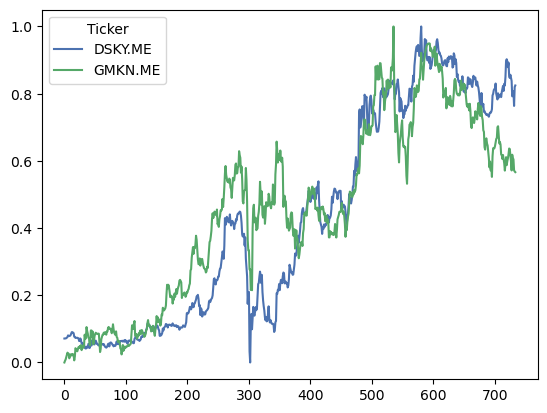

In [215]:
df_cluster.plot(y=['DSKY.ME','GMKN.ME'])

<Axes: >

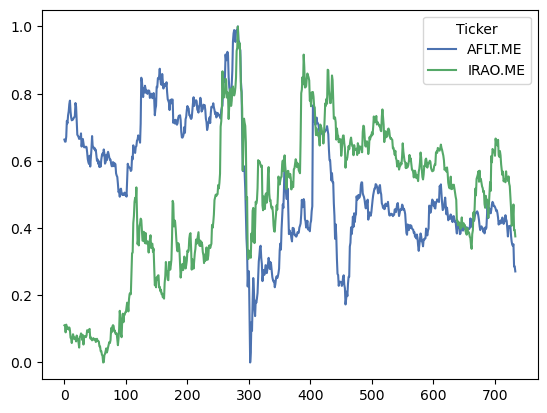

In [235]:
df_cluster.plot(y = ['AFLT.ME', 'IRAO.ME'])